Arbitrage Analysis & Regression-Based Forecasting


-  Linear Regression | Predict fair value from inputs | Regression, residual analysis
- Arbitrage | Limit Order Book vs Conversion Price | Compare prices if both markets exist
- Fair Value MM | Market make near predicted value | Error vs spread analysis

We can trade macarons in our local market, and we can trade them in the international market. If we want to buy them on the international market, we need to pay the askPrice, import tariff, and transport fees. If we want to sell them on the international market, we need to pay the bidPrice, export tariff, and transport fees. An arbitrage opportunity may be possible if the price difference between the local market and the international market is greater than the sum of the import tariff, export tariff, and transport fees.


In [2]:
import pandas as pd
import os
import glob
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [3]:

def load_historical_data(directory_path):
    historical_data = {}
    days = [1, 2, 3]

    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found: {directory_path}")
        return historical_data

    print(f"Loading historical data for Round 4 from: {directory_path}")

    for day in days:
        day_data = {}
        day_str = str(day)

        prices_pattern = os.path.join(directory_path, f'prices_round_4_day_{day_str}.csv')
        trades_pattern = os.path.join(directory_path, f'trades_round_4_day_{day_str}_nn.csv')
        observations_pattern = os.path.join(directory_path, f'observations_round_4_day_{day_str}.csv')

        price_files = glob.glob(prices_pattern)
        trade_files = glob.glob(trades_pattern)
        observations_files = glob.glob(observations_pattern)

        if price_files:
            prices_file_path = price_files[0]
            df_prices = pd.read_csv(prices_file_path, sep=';')
            df_prices['timestamp'] += (day - 1) * 1_000_000
            df_prices['day'] = day
            day_data['prices'] = df_prices

        if trade_files:
            trades_file_path = trade_files[0]
            df_trades = pd.read_csv(trades_file_path, sep=';')
            df_trades['timestamp'] += (day - 1) * 1_000_000
            df_trades['day'] = day
            day_data['trades'] = df_trades

        if observations_files:
            observations_file_path = observations_files[0]
            df_observations = pd.read_csv(observations_file_path, sep=',')
            df_observations['timestamp'] += (day - 1) * 1_000_000
            df_observations['day'] = day
            day_data['observations'] = df_observations

        if day_data:
            historical_data[day] = day_data

    return historical_data

# Load the data
directory_path = 'C:/Users/Admin/projects/prosperity-poj/strategy/round4/resources/round4'
historical_data = load_historical_data(directory_path)

# Combine all data
all_prices = pd.concat([data['prices'] for data in historical_data.values() if 'prices' in data], ignore_index=True)
all_trades = pd.concat([data['trades'] for data in historical_data.values() if 'trades' in data], ignore_index=True)
all_observations = pd.concat([data['observations'] for data in historical_data.values() if 'observations' in data], ignore_index=True)

# Display info
print(all_prices.head())
print(all_trades.head())
print(all_observations.head())

# Initial Data Analysis
print("Price Columns:", all_prices.columns)
print("Trade Columns:", all_trades.columns)
print("Observation Columns:", all_observations.columns)


Loading historical data for Round 4 from: C:/Users/Admin/projects/prosperity-poj/strategy/round4/resources/round4
   day  timestamp                     product  bid_price_1  bid_volume_1  \
0    1          0               VOLCANIC_ROCK      10515.0         143.0   
1    1          0              PICNIC_BASKET1      58705.0          12.0   
2    1          0              PICNIC_BASKET2      30252.0          12.0   
3    1          0  VOLCANIC_ROCK_VOUCHER_9500       1015.0          12.0   
4    1          0  VOLCANIC_ROCK_VOUCHER_9750        766.0          12.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0      10514.0          57.0          NaN           NaN        10517   
1      58704.0          27.0          NaN           NaN        58716   
2      30251.0          27.0          NaN           NaN        30258   
3          NaN           NaN          NaN           NaN         1017   
4          NaN           NaN          NaN           NaN          767 

In [4]:
#Identify arbitrage opportunities


all_prices= all_prices.merge(all_observations, on='timestamp', how='left')


# Filter for MAGNIFICENT_MACARONS (already done in your snippet)
all_prices = all_prices[all_prices['product'] == 'MAGNIFICENT_MACARONS'].copy() # Use .copy() to avoid SettingWithCopyWarning

# Calculate effective conversion prices
# Price to BUY from Chefs (Pristine Cuisine)
all_prices['conversion_buy_price_effective'] = all_prices['askPrice'] + all_prices['transportFees'] + all_prices['importTariff']
# Price to SELL to Chefs (Pristine Cuisine)
all_prices['conversion_sell_price_effective'] = all_prices['bidPrice'] - all_prices['transportFees'] - all_prices['exportTariff']

# --- Arbitrage Scenario 1: Buy on Market, Sell to Chefs ---
# Condition: Market Ask Price < Effective Conversion Sell Price
all_prices['arb1_possible'] = all_prices['ask_price_1'] < all_prices['conversion_sell_price_effective']
all_prices['arb1_profit_per_unit'] = all_prices['conversion_sell_price_effective'] - all_prices['ask_price_1']

# --- Arbitrage Scenario 2: Buy from Chefs, Sell on Market ---
# Condition: Effective Conversion Buy Price < Market Bid Price
all_prices['arb2_possible'] = all_prices['conversion_buy_price_effective'] < all_prices['bid_price_1']
all_prices['arb2_profit_per_unit'] = all_prices['bid_price_1'] - all_prices['conversion_buy_price_effective']

# Filter to show only timestamps where arbitrage is possible
arbitrage_opportunities = all_prices[
    (all_prices['arb1_possible']) | (all_prices['arb2_possible'])
].copy()

# Select and rename columns for clarity
arbitrage_opportunities = arbitrage_opportunities[[
    'timestamp',
    'ask_price_1', 'bid_price_1', # Market Prices
    'conversion_buy_price_effective', 'conversion_sell_price_effective', # Chef Prices
    'arb1_possible', 'arb1_profit_per_unit',
    'arb2_possible', 'arb2_profit_per_unit'
]]

print("\nArbitrage Opportunities Found:")
if arbitrage_opportunities.empty:
    print("No arbitrage opportunities detected in the analyzed data.")
else:
    print(f"Total arbitrage instances found: {len(arbitrage_opportunities)}")
    print("\nArbitrage Scenario 1 (Buy Market, Sell Chef):")
    print(arbitrage_opportunities[arbitrage_opportunities['arb1_possible']][['timestamp', 'ask_price_1', 'conversion_sell_price_effective', 'arb1_profit_per_unit']].head())
    print(f"Count: {arbitrage_opportunities['arb1_possible'].sum()}")

    print("\nArbitrage Scenario 2 (Buy Chef, Sell Market):")
    print(arbitrage_opportunities[arbitrage_opportunities['arb2_possible']][['timestamp', 'conversion_buy_price_effective', 'bid_price_1', 'arb2_profit_per_unit']].head())
    print(f"Count: {arbitrage_opportunities['arb2_possible'].sum()}")

    # Display some overall stats for context
    print("\nOverall Data Sample (showing potential arbitrage columns):")
    print(all_prices[[
        'timestamp','ask_price_1', 'bid_price_1',
        'conversion_buy_price_effective', 'conversion_sell_price_effective',
        'arb1_possible', 'arb2_possible'
        ]].head())
    print(all_prices[[
        'timestamp','ask_price_1', 'bid_price_1',
        'conversion_buy_price_effective', 'conversion_sell_price_effective',
        'arb1_possible', 'arb2_possible'
        ]].tail())




Arbitrage Opportunities Found:
Total arbitrage instances found: 782

Arbitrage Scenario 1 (Buy Market, Sell Chef):
Empty DataFrame
Columns: [timestamp, ask_price_1, conversion_sell_price_effective, arb1_profit_per_unit]
Index: []
Count: 0

Arbitrage Scenario 2 (Buy Chef, Sell Market):
      timestamp  conversion_buy_price_effective  bid_price_1  \
311        2000                           643.5        644.0   
1505      10000                           627.0        628.0   
2795      18600                           615.0        616.0   
3381      22500                           613.0        615.0   
4243      28200                           601.0        602.0   

      arb2_profit_per_unit  
311                    0.5  
1505                   1.0  
2795                   1.0  
3381                   2.0  
4243                   1.0  
Count: 782

Overall Data Sample (showing potential arbitrage columns):
    timestamp  ask_price_1  bid_price_1  conversion_buy_price_effective  \
6       

Analysis of Market Bots

Total MAGNIFICENT_MACARONS trades: 1081

Analyzed MAGNIFICENT_MACARONS Market Trades:
      timestamp  price  quantity trade_side
80         3000  660.0         5        BUY
316       17300  614.0         2        BUY
359       19800  624.0         7        BUY
381       20900  626.0         4        BUY
403       22500  615.0         2       SELL
467       26700  601.0         7       SELL
583       34000  583.0         2       SELL
744       41700  574.0         4       SELL
782       44500  570.0         4       SELL
842       46700  584.0         7       SELL
858       47600  580.0         4       SELL
884       48300  579.0         3        BUY
891       48700  575.0         5       SELL
892       48700  575.0         2       SELL
1027      55300  589.0         7        BUY
1083      57900  603.0         4        BUY
1089      58300  600.0         5        BUY
1140      61300  606.0         4        BUY
1205      63300  596.0         7       SELL
1207      63400  601.0         7  

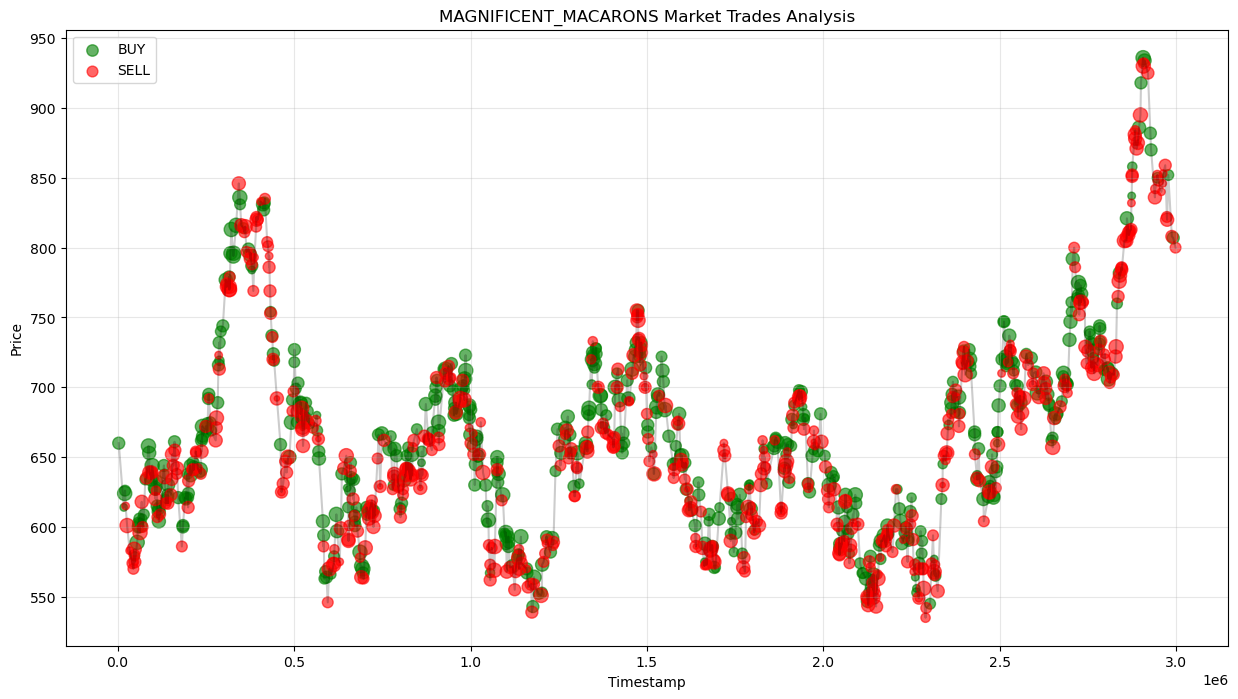


Largest Consecutive Trade Groups (same side):
                       timestamp                quantity  price         \
                           first     last count      sum    min    max   
trade_group trade_side                                                   
309         BUY          1739100  1769900     9       44  581.0  623.0   
447         BUY          2506400  2519900     8       38  715.0  747.0   
70          SELL          380700   405000     8       30  769.0  833.0   
520         SELL         2949700  2974400     7       25  820.0  859.0   
2           SELL           22500    47600     7       30  570.0  615.0   
506         SELL         2865200  2873200     7       26  809.0  832.0   
504         SELL         2840800  2859700     7       38  780.0  808.0   
429         BUY          2408800  2429000     7       36  666.0  727.0   
248         SELL         1390000  1407300     6       27  657.0  666.0   
416         SELL         2341000  2354300     6       28  648.0  

In [ ]:
macaron_trades = all_trades[all_trades['symbol'] == 'MAGNIFICENT_MACARONS'].copy()
print(f"Total MAGNIFICENT_MACARONS trades: {len(macaron_trades)}")


price_lookup = all_prices[['timestamp', 'bid_price_1', 'ask_price_1']].copy()

# determine if a trade is a buy or sell based on price matching
def determine_trade_side(trade_row, price_df):
    
    trade_time = trade_row['timestamp']
    trade_price = trade_row['price']
    
    
    prev_prices = price_df[price_df['timestamp'] <= trade_time].sort_values('timestamp', ascending=False)
    
    if prev_prices.empty:
        return "UNKNOWN"
    
    closest_price = prev_prices.iloc[0]
    
    
    if abs(trade_price - float(closest_price['ask_price_1'])) < 0.1:
        return "BUY"
    
    elif abs(trade_price - float(closest_price['bid_price_1'])) < 0.1:
        return "SELL"
    else:
        
        if abs(trade_price - float(closest_price['bid_price_1'])) < abs(trade_price - float(closest_price['ask_price_1'])):
            return "SELL"  
        else:
            return "BUY"   


macaron_trades['trade_side'] = macaron_trades.apply(
    lambda row: determine_trade_side(row, price_lookup), axis=1
)


macaron_trades = macaron_trades.sort_values('timestamp')


print("\nAnalyzed MAGNIFICENT_MACARONS Market Trades:")
print(macaron_trades[['timestamp', 'price', 'quantity', 'trade_side']].head(20))

# Calculate some statistics
print("\nTrade Side Distribution:")
print(macaron_trades['trade_side'].value_counts())

print("\nAverage Trade Size by Side:")
print(macaron_trades.groupby('trade_side')['quantity'].mean())

print("\nTotal Volume by Side:")
print(macaron_trades.groupby('trade_side')['quantity'].sum())


import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))


buys = macaron_trades[macaron_trades['trade_side'] == 'BUY']
sells = macaron_trades[macaron_trades['trade_side'] == 'SELL']


plt.scatter(buys['timestamp'], buys['price'], c='green', label='BUY', s=buys['quantity']*15, alpha=0.6)
plt.scatter(sells['timestamp'], sells['price'], c='red', label='SELL', s=sells['quantity']*15, alpha=0.6)


plt.plot(macaron_trades['timestamp'], macaron_trades['price'], 'k-', alpha=0.2)

plt.title('MAGNIFICENT_MACARONS Market Trades Analysis')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


macaron_trades['side_change'] = macaron_trades['trade_side'].shift() != macaron_trades['trade_side']
macaron_trades['trade_group'] = macaron_trades['side_change'].cumsum()

trade_groups = macaron_trades.groupby(['trade_group', 'trade_side']).agg({
    'timestamp': ['first', 'last', 'count'],
    'quantity': 'sum',
    'price': ['min', 'max', 'mean']
})


largest_groups = trade_groups.sort_values([('timestamp', 'count')], ascending=False).head(10)
print("\nLargest Consecutive Trade Groups (same side):")
print(largest_groups)


macaron_trades['price_change'] = macaron_trades['price'].diff()
macaron_trades['price_pct_change'] = macaron_trades['price'].pct_change() * 100

print("\nPrice Movement Statistics:")
print(macaron_trades[['price_change', 'price_pct_change']].describe())


Predicting Macaron prices

Index(['day_x', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'bidPrice', 'askPrice', 'transportFees', 'exportTariff', 'importTariff',
       'sugarPrice', 'sunlightIndex', 'day_y',
       'conversion_buy_price_effective', 'conversion_sell_price_effective',
       'arb1_possible', 'arb1_profit_per_unit', 'arb2_possible',
       'arb2_profit_per_unit', 'trade_dir', 'volume', 'dir_ma_1', 'vol_ma_1',
       'dir_ma_5', 'vol_ma_5', 'dir_ma_10', 'vol_ma_10', 'dir_ma_20',
       'vol_ma_20'],
      dtype='object')
LinearRegression: RMSE=0.3866, R²=1.0000
Ridge: RMSE=0.5254, R²=1.0000
Lasso: RMSE=0.3863, R²=1.0000

Best model: Lasso


C:\Users\Admin\AppData\Local\Temp\ipykernel_36376\493118715.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[trade_cols] = df[trade_cols].fillna(method='ffill').fillna(0)


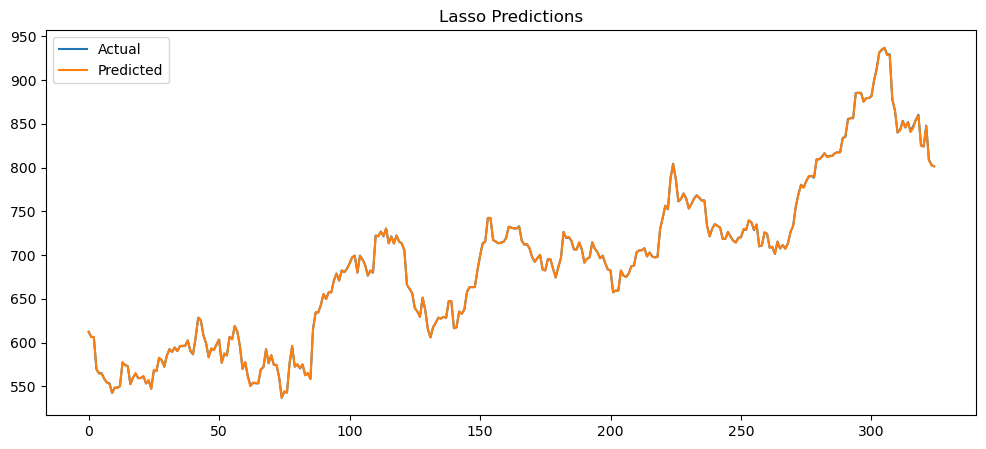


Model coefficients for implementation:
Intercept: 652.347884
price_lag_1: 57.196501
price_chg_1: 2.755986
price_lag_3: 0.166934
price_lag_5: 0.042567
price_chg_3: 0.026266
sunlight_chg_3: -0.017848
dir_ma_5: -0.013114
sunlight_chg_5: -0.005592
spread: -0.004545
sunlightIndex: -0.002887
sugarPrice: 0.001885
sunlight_chg_1: -0.001616
sugar_sun: -0.000000
tariff_total: 0.000000
vol_ma_5: -0.000000
dir_ma_10: -0.000000
price_chg_5: 0.000000
sugar_chg_1: 0.000000
sugar_chg_3: 0.000000
sugar_chg_5: -0.000000
importTariff: -0.000000
exportTariff: -0.000000
transportFees: 0.000000
dir_ma_1: -0.000000

Prediction formula:
price = 652.347884 + 0.001885 * sugarPrice - 0.002887 * sunlightIndex + 0.000000 * transportFees + 0.000000 * exportTariff + 0.000000 * importTariff - 0.013114 * dir_ma_5 + 0.000000 * dir_ma_10 + 0.000000 * vol_ma_5 - 0.004545 * spread + 0.000000 * tariff_total + 0.000000 * sugar_sun + 2.755986 * price_chg_1 - 0.001616 * sunlight_chg_1 - 0.017848 * sunlight_chg_3 - 0.005592 *

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# filter data for macarons
macaron_data = all_prices[all_prices['product']== 'MAGNIFICENT_MACARONS'].copy()
macaron_trades = all_trades[all_trades['symbol'] == 'MAGNIFICENT_MACARONS'].copy()

# determine trade direction
def get_trade_side(row, prices):
    time = row['timestamp']
    price = row['price']
    prev = prices[prices['timestamp'] <= time].sort_values('timestamp', ascending=False)
    if prev.empty:
        return 0
    closest = prev.iloc[0]
    if abs(price - float(closest['ask_price_1'])) < abs(price - float(closest['bid_price_1'])):
        return 1  # buy
    else:
        return -1  # sell

macaron_trades['trade_dir'] = macaron_trades.apply(lambda r: get_trade_side(r, macaron_data), axis=1)
macaron_trades = macaron_trades.sort_values('timestamp')

# create trade features dataframe
trade_features = pd.DataFrame()
trade_features['timestamp'] = macaron_trades['timestamp']
trade_features['trade_dir'] = macaron_trades['trade_dir']
trade_features['volume'] = macaron_trades['quantity']

# calculate rolling features
for w in [1, 5, 10, 20]:
    trade_features[f'dir_ma_{w}'] = trade_features['trade_dir'].rolling(w).mean().fillna(0)
    trade_features[f'vol_ma_{w}'] = trade_features['volume'].rolling(w).mean().fillna(0)

# merge all data
df = macaron_data.merge(trade_features, on = 'timestamp', how = 'left' )
print(df.columns)
# fill missing values
trade_cols = [c for c in df.columns if c.startswith('dir_ma_') or c.startswith('vol_ma_')]
df[trade_cols] = df[trade_cols].fillna(method='ffill').fillna(0)

# feature engineering
df['spread'] = df['ask_price_1'] - df['bid_price_1']
df['mid_price'] = (df['ask_price_1'] + df['bid_price_1']) / 2
df['tariff_total'] = abs(df['importTariff']) + abs(df['exportTariff'])
df['sugar_sun'] = df['sugarPrice'] * df['sunlightIndex']

# lag features
for lag in [1, 3, 5]:
    df[f'price_lag_{lag}'] = df['mid_price'].shift(lag)
    df[f'price_chg_{lag}'] = df['mid_price'].pct_change(lag)
    df[f'sunlight_chg_{lag}'] = df['sunlightIndex'].pct_change(lag)
    df[f'sugar_chg_{lag}'] = df['sugarPrice'].pct_change(lag)

df = df.dropna()

# define features and target
features = [
    'sugarPrice', 'sunlightIndex', 'transportFees', 'exportTariff', 'importTariff',
    'dir_ma_5', 'dir_ma_10', 'vol_ma_5', 'spread', 'tariff_total', 'sugar_sun', 'price_chg_1', 'sunlight_chg_1', 'sunlight_chg_3', 'sunlight_chg_5', 'price_chg_3', 'price_chg_5',
    'sugar_chg_1', 'sugar_chg_3', 'sugar_chg_5' , 'price_lag_1', 'price_lag_3', 'price_lag_5', 'dir_ma_1'
]

X = df[features]
y = df['mid_price']

# train/test split by time
split_idx = int(len(df) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=0.5),
    'Lasso': Lasso(alpha=0.01)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'rmse': rmse, 'r2': r2, 'model': model}
    print(f"{name}: RMSE={rmse:.4f}, R²={r2:.4f}")

# select best model
best_name = min(results, key=lambda m: results[m]['rmse'])
best_model = results[best_name]['model']
print(f"\nBest model: {best_name}")

# plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(best_model.predict(X_test_scaled), label='Predicted')
plt.legend()
plt.title(f"{best_name} Predictions")
plt.show()

# export model coefficients for algorithm implementation
coefs = pd.DataFrame({
    'feature': features,
    'coefficient': best_model.coef_,
    'abs_value': np.abs(best_model.coef_)
}).sort_values('abs_value', ascending=False)

print("\nModel coefficients for implementation:")
print(f"Intercept: {best_model.intercept_:.6f}")
for i, row in coefs.iterrows():
    print(f"{row['feature']}: {row['coefficient']:.6f}")

# formula for manual implementation
formula = f"price = {best_model.intercept_:.6f}"
for feature, coef in zip(features, best_model.coef_):
    sign = '+' if coef >= 0 else '-'
    formula += f" {sign} {abs(coef):.6f} * {feature}"

print(f"\nPrediction formula:\n{formula}")

# function to manually predict using coefficients
def predict_price(features_dict):
    # standardize inputs using same scaler
    input_scaled = scaler.transform(pd.DataFrame([features_dict], columns=features))
    # apply formula
    return best_model.intercept_ + np.sum(best_model.coef_ * input_scaled[0])

# example usage
print("\nExample prediction:")
sample_features = {f: X.iloc[-1][f] for f in features}
print(f"Predicted price: {predict_price(sample_features):.2f}")